# sales Analysis Task 

## Abdullah Almaharmeh 

In [151]:
#import libraires 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
import os
import warnings
import calendar

warnings.filterwarnings(action='ignore')

In [105]:
# create dataframe to combine all csv files into one 

combine = pd.DataFrame()

In [106]:
directory = '/home/abdullah/Desktop/All files /Abdullah file/umniah_task'

# iterate over files that end with 'csv' and combine them with combine dataframe 
for file in os.listdir(directory):
    if file.endswith('.csv'):
        path = os.path.join(directory,file)
        temp_df = pd.read_csv(path)
        combine = pd.concat([combine,temp_df])
        
combine.reset_index(drop=True,inplace=True)

In [107]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298146 entries, 0 to 298145
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          297285 non-null  object
 1   Product           297285 non-null  object
 2   Quantity Ordered  297285 non-null  object
 3   Price Each        297285 non-null  object
 4   Order Date        297285 non-null  object
 5   Purchase Address  297285 non-null  object
dtypes: object(6)
memory usage: 13.6+ MB


we can notice that order date column (object) type so we need to change it to datetype 

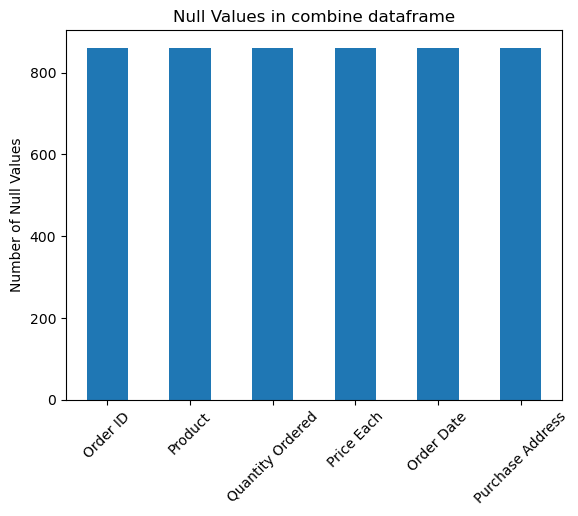

In [108]:
# check null values 
null = combine.isna().sum()

null.plot(kind='bar')
plt.title('Null Values in combine dataframe')
plt.ylabel('Number of Null Values')
plt.xticks(rotation = 45)
plt.show()

we can see that we have null values near to 800, so we want to deal with it too.

In [109]:
combine.dropna(inplace=True)

In [110]:
# now we want to try to change the column datatype

try : 
    combine['Order Date'] = pd.to_datetime(combine['Order Date'])
except Exception as e : 
    print(repr(e))

DateParseError('Unknown datetime string format, unable to parse: Order Date, at position 241')


As we see in the error message that we have "unknown datetime fromat" so we can't parse it into a sute datetype.

the error message also contains the position where we have the issue(241) so we want to check it, and generlize the problem.

In [111]:
# checking the position 241 

combine[combine.index == 241]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
241,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


wow !

we find that we may find some columns name in the recoreds and this is invalid recored.

so let's check if we have more columns with the same problem 

In [112]:
print(combine[combine['Order ID'] == 'Order ID'].shape)

combine[combine['Order ID'] == 'Order ID']


(548, 6)


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
241,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
345,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
887,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1797,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2339,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
...,...,...,...,...,...,...
295754,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
296697,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
297327,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
297605,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


so we can findout that there is 548 rows have the same issue, we will deal with this issue, let's consider it at first as duplicates data then remove the remain column

In [113]:
# check duplication 

duplicates = combine.duplicated().sum()

print('In this dataframe we have',duplicates,'duplicated rows.')

In this dataframe we have 932 duplicated rows.


In [114]:
combine.drop_duplicates(inplace=True)


In [115]:
# if we check the probelm again,we can find that we have just one column with that problem.
combine[combine['Order ID'] == 'Order ID']

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
241,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [116]:
# i can just remove the row with index 241 wich is a choice in my case 
combine.drop(index=241,inplace=True)


In [137]:
#change data types 
combine['Order Date'] = pd.to_datetime(combine['Order Date'])
combine['Quantity Ordered'] = pd.to_numeric(combine['Quantity Ordered'])
combine['Price Each'] = pd.to_numeric(combine['Price Each'])
combine['Order ID'] = pd.to_numeric(combine['Order ID'])

In [118]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296352 entries, 0 to 298145
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          296352 non-null  object        
 1   Product           296352 non-null  object        
 2   Quantity Ordered  296352 non-null  int64         
 3   Price Each        296352 non-null  float64       
 4   Order Date        296352 non-null  datetime64[ns]
 5   Purchase Address  296352 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 15.8+ MB


##### Now we are ready to go !


before start getting insight from the data we want to play with date type and create some majic with it.

we need to extract the month day and year to make analysis 

In [119]:
combine['Date'] = combine['Order Date'].dt.strftime('%Y-%m-%d')
combine['Time'] = combine['Order Date'].dt.strftime('%T')
combine['Day'] = combine['Order Date'].dt.strftime('%A')
combine['Month'] = combine['Order Date'].dt.strftime('%b')
combine['Year'] = combine['Order Date'].dt.strftime('%Y')

after i have extracted what i want from the 'Order Date' column i want to try to extract information from 'Purchase Address' column.

after searching, finally i can explain what is content of the column represents :- 
let's take the first address 934 Highland St, New York City, NY 10001

* 934 :- represnts the street number 
* Highland St :- represnts the street name 
* New York City :- represnts the name of the city where the ordered has deliverd 
* NY :- This is the two-letter abbreviation for the state in which the city is located.
* 10001 :- represents the zip code/postal code

based on my intention i want to create 3 columns (state,city, zipcode)

In [135]:
# I want to create function to split the address, and apply it on the dataframe
def s_split(s):
    s = s.split(", ")
    city = s[1]
    state = s[2].split()[0]
    ZIP_code = s[2].split()[1]
    return city,state,ZIP_code

combine[['City','State','ZIP cod']] = combine['Purchase Address'].apply(s_split).apply(pd.Series)

In [138]:
combine.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Date,Time,Day,Month,Year,City,State,ZIP cod
0,257338,AAA Batteries (4-pack),1,2.99,2020-10-19 16:23:00,"934 Highland St, New York City, NY 10001",2020-10-19,16:23:00,Monday,Oct,2020,New York City,NY,10001
1,257339,Macbook Pro Laptop,1,1700.00,2020-10-07 13:38:00,"51 Center St, New York City, NY 10001",2020-10-07,13:38:00,Wednesday,Oct,2020,New York City,NY,10001
2,257340,iPhone,1,700.00,2020-10-31 20:28:00,"859 Jackson St, Portland, OR 97035",2020-10-31,20:28:00,Saturday,Oct,2020,Portland,OR,97035
3,257341,Bose SoundSport Headphones,1,99.99,2020-10-04 01:57:00,"486 Johnson St, Boston, MA 02215",2020-10-04,01:57:00,Sunday,Oct,2020,Boston,MA,02215
4,257342,AAA Batteries (4-pack),1,2.99,2020-10-14 08:26:00,"965 8th St, Dallas, TX 75001",2020-10-14,08:26:00,Wednesday,Oct,2020,Dallas,TX,75001


In [140]:
# I want to create dataframe to apply all anlysis on it 

analysis = combine.copy()

analysis.drop(['Order Date','Purchase Address'],axis=1,inplace=True)

In [141]:
analysis.head()

,Order ID,Product,Quantity Ordered,Price Each,Date,Time,Day,Month,Year,City,State,ZIP cod
0,257338,AAA Batteries (4-pack),1,2.99,2020-10-19,16:23:00,Monday,Oct,2020,New York City,NY,10001
1,257339,Macbook Pro Laptop,1,1700.00,2020-10-07,13:38:00,Wednesday,Oct,2020,New York City,NY,10001
2,257340,iPhone,1,700.00,2020-10-31,20:28:00,Saturday,Oct,2020,Portland,OR,97035
3,257341,Bose SoundSport Headphones,1,99.99,2020-10-04,01:57:00,Sunday,Oct,2020,Boston,MA,02215
4,257342,AAA Batteries (4-pack),1,2.99,2020-10-14,08:26:00,Wednesday,Oct,2020,Dallas,TX,75001


# Analysis part

### we want to analyze the monthly sales trends 

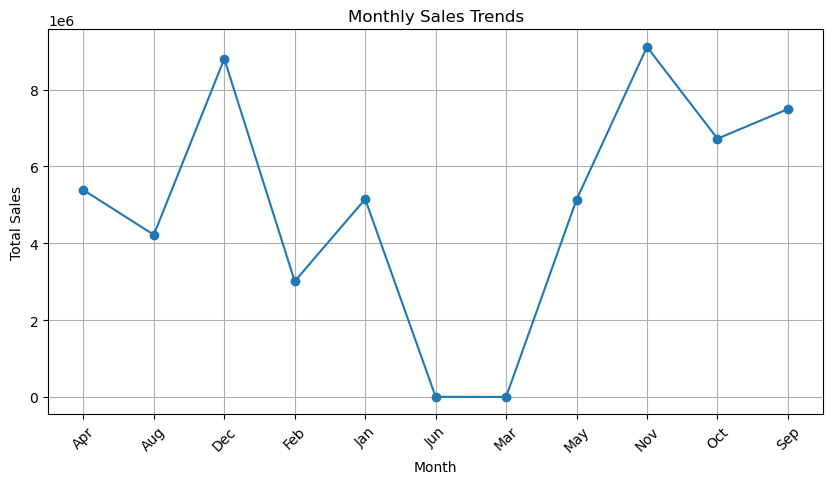

In [156]:
# groupby month and sum price for each order 
monthly_sales = analysis.groupby('Month')['Price Each'].sum().reset_index()

#create linePlot 

plt.figure(figsize=(10, 5))
plt.plot(monthly_sales['Month'], monthly_sales['Price Each'], marker='o', linestyle='-')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()


from this plot we can say that :- 

* December stands out as the peak sales month with total sales of 8,799,609.66, likely due to holiday shopping.
* January and November also exhibit strong sales figures, indicating post-holiday and pre-holiday shopping periods.
* March and June have notably lower sales figures, possibly reflecting seasonal sales trends.

### Day-of-the-Week Analysis :- highest and lowest sales in the days of the week .

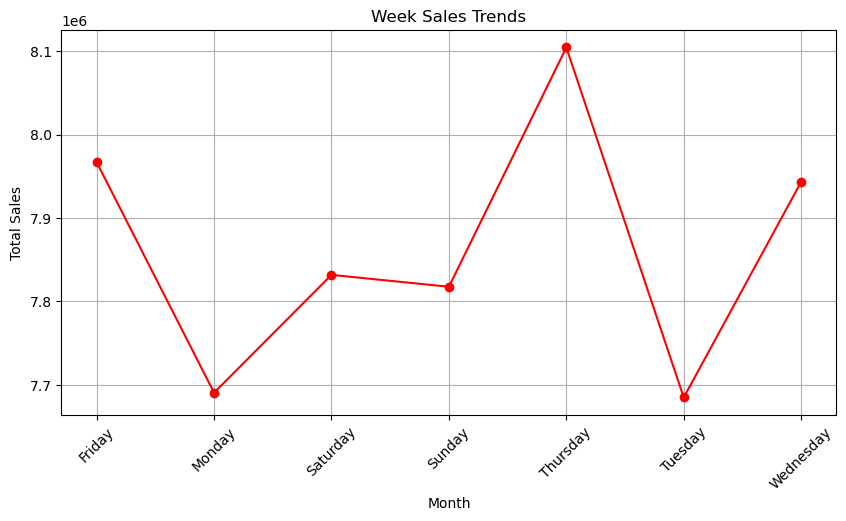

In [159]:
# groupby month and sum price for each order 
days_sales = analysis.groupby('Day')['Price Each'].sum().reset_index()

#create linePlot 

plt.figure(figsize=(10, 5))
plt.plot(days_sales['Day'], days_sales['Price Each'], marker='o', linestyle='-',color ='r')
plt.title('Week Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()


from this line plot we can extract these resutls 

* Thursday exhibits the highest total sales at 8,104,519.62, making it the most lucrative day of the week.
* Wednesday and Sunday closely follow, with total sales of 7,943,419.12 and 7,817,554.05, respectively.
* Friday, Saturday, and Monday also show strong sales figures, indicating consistently high sales performance throughout the week.
* Tuesday has the lowest total sales among the weekdays, suggesting a slight dip in sales activity.

### compare between years sales 

In [161]:
year_sales = analysis.groupby('Year')['Price Each'].sum().reset_index()

In [162]:
year_sales

,Year,Price Each
0,2020,29567593.72
1,2021,25464502.13
2,2022,7517.96


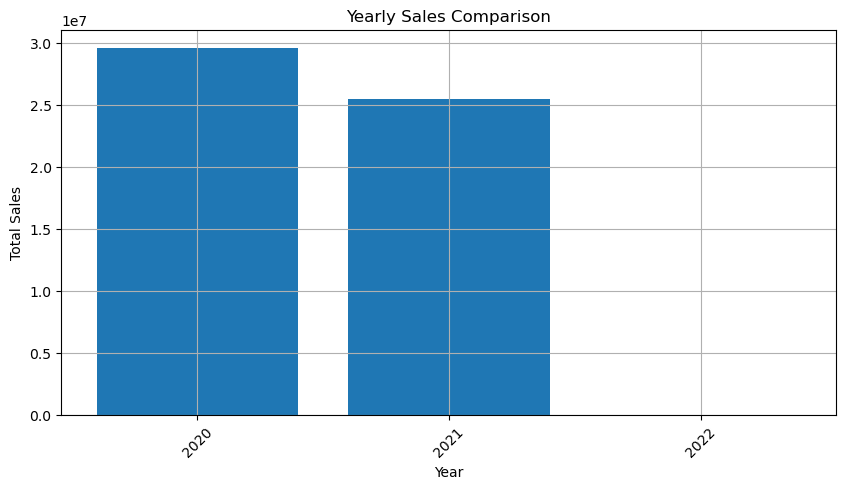

In [169]:
plt.figure(figsize=(10, 5))
plt.bar(year_sales['Year'], year_sales['Price Each'])
plt.title('Yearly Sales Comparison')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()

we can see that years 2021 and 2020 have nearly total sales, but 2022 have a strong drop.

before jump to conclusion, we want to check if 2022 took a fair percentage in the dataset.

In [173]:
analysis[analysis.Year == "2022"].Month.value_counts()

Month
Jan    40
Name: count, dtype: int64

we can noticed that there is just 40 elemnts for year 2022 and they are on Jan, so we may predict that the data collection stops near that date.

maybeee!

### Morning, Afternoon and Night sales !

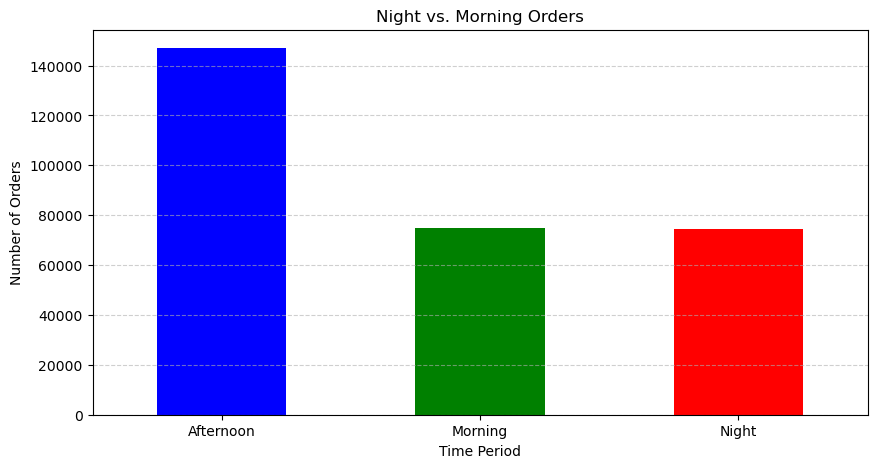

In [175]:
# create a copy from the data frame and add the hour column for it

df = analysis.copy()
# add hour column to the new dataframe
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

# create funciton to define day periouds 

def categorize_time(hour):
    if 4 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 20:
        return 'Afternoon'
    else:
        return 'Night'

# Apply the function and add time period column in the temporary dataframe
df['Time Period'] = df['Hour'].apply(categorize_time)


time_period_counts = df['Time Period'].value_counts().sort_index()

# Create a stylish trend plot
plt.figure(figsize=(10, 5))
time_period_counts.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Night vs. Morning Orders')
plt.xlabel('Time Period')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

* The 'Afternoon' time period represents the most common time for orders, with a total of 147,039 orders. This suggests that a significant portion of orders occurs during the afternoon hours.
* 'Morning' orders follow closely, with 74,905 orders, indicating a substantial volume of early-morning sales.
* 'Night' orders, with 74,408 orders, are slightly less frequent but still noteworthy, demonstrating that sales continue into the evening.

This analysis provides an understanding of the distribution of orders throughout the day, which can be valuable for scheduling, staffing, and operational decisions within the business

### Top selling product 

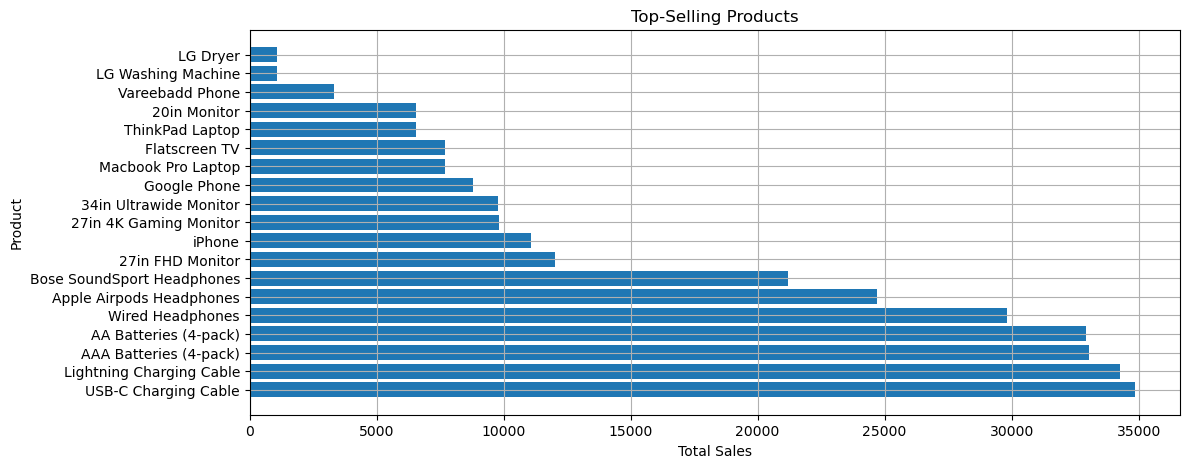

In [244]:
product_sales = analysis.groupby('Product')['Order ID'].count().reset_index()

product_sales = product_sales.sort_values(by='Order ID',ascending=False)

plt.figure(figsize=(12, 5))
plt.barh(product_sales['Product'], product_sales['Order ID'])
plt.title('Top-Selling Products')
plt.xlabel('Total Sales')
plt.ylabel('Product')
plt.grid(True)
plt.show()

we can see that the most selling products something like cables, battaries, headphones let's call them accesories.

so let's discover if there is relationship between product price and how many orders we get for it. 

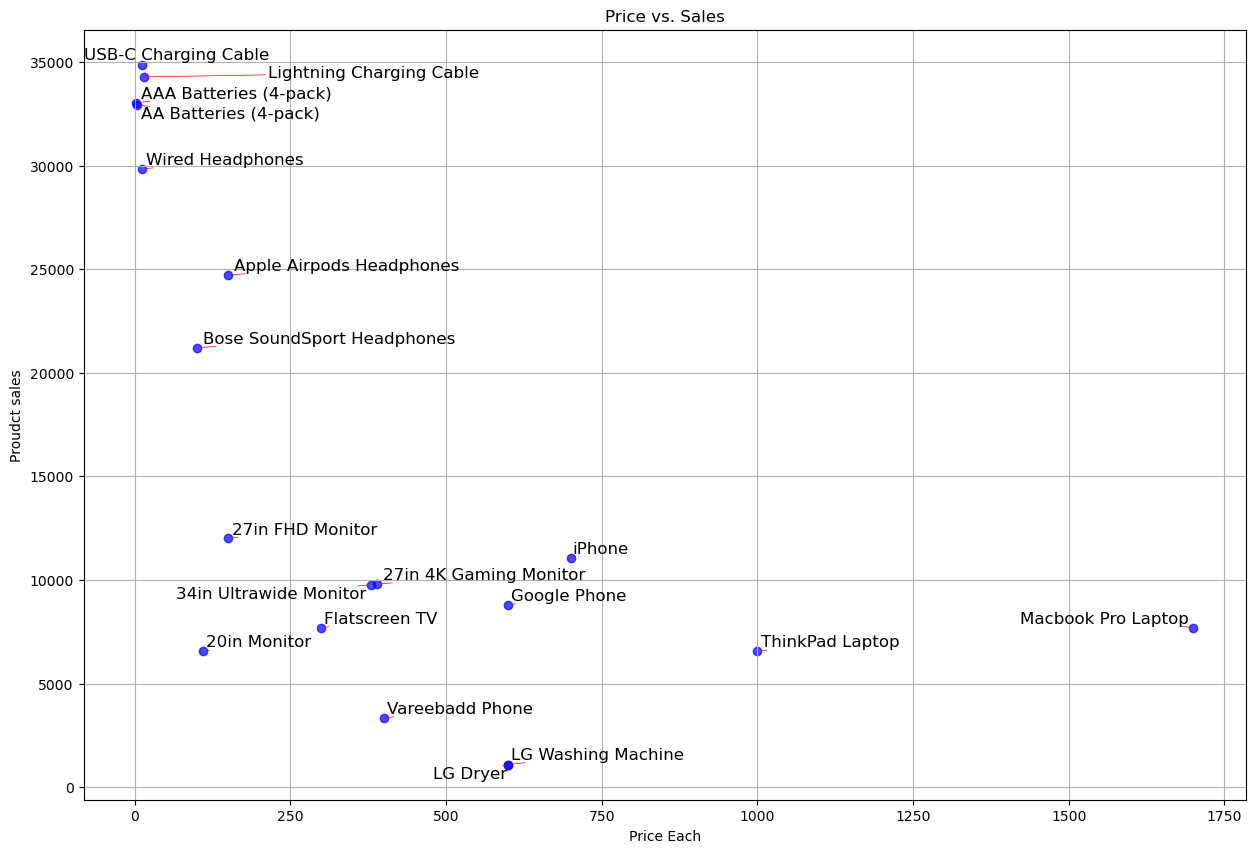

In [245]:
product_sales = pd.merge(product_sales,analysis[['Product','Price Each']],on='Product',how='left')
product_sales.drop_duplicates(inplace=True)
product_sales.reset_index(drop=True)

from adjustText import adjust_text
plt.figure(figsize=(15, 10))
plt.scatter(product_sales['Price Each'], product_sales['Order ID'], marker='o', color='blue', alpha=0.7)
plt.title('Price vs. Sales')
plt.xlabel('Price Each')
plt.ylabel('Proudct sales')
plt.grid(True)

texts = [plt.text(row['Price Each'], row['Order ID'], row['Product'], fontsize=12, ha='left', va='bottom') for i, row in product_sales.iterrows()]

# use this library for better text style and appearance.

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r', lw=0.5))

plt.show()


from this graph we can see that the cheapest products most likely to sell, and the personal products is most likely to be sold 

### geographical analysis 

In [250]:
import plotly.express as px
geo_sales = analysis.groupby('State')['Price Each'].sum().reset_index()

In [254]:
fig = px.choropleth(
    geo_sales,
    locations='State',
    locationmode='USA-states',
    color='Price Each',
    scope='usa',
    title='Sales by U.S. State',
)

fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="white")



we can see that CA is the best performing area and ME is the worst, so we want to descuss this with sales and market team 

# Q3 in the task 


### If you see that this data can be used to build ML models, prepare for this as an idea (implementation is a plus).

I think we can use this data to apply one or more Ml application, this historical data can used to :-

* build recommendation system based on orders customer take, and the location of these orders .

* Anomaly Detection: Detect unusual or fraudulent transactions by building an anomaly detection model to identify irregular patterns in the data.


* Sales Forecasting :- we can group data by months and try to predict the next month sales .

### End of the task 